In [19]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder as le
from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


from sklearn.metrics import accuracy_score, f1_score


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [58]:
val_data = pd.read_excel("/content/drive/MyDrive/KH competetion/test_loan_data (1).xlsx")

In [37]:
val_data.columns


Index(['addr_state', 'annual_inc', 'earliest_cr_line', 'emp_length',
       'emp_title', 'fico_range_high', 'fico_range_low', 'grade',
       'home_ownership', 'application_type', 'initial_list_status', 'int_rate',
       'loan_amnt', 'num_actv_bc_tl', 'mort_acc', 'tot_cur_bal', 'open_acc',
       'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util',
       'sub_grade', 'term', 'title', 'total_acc', 'verification_status'],
      dtype='object')

In [38]:
df.columns

Index(['addr_state', 'annual_inc', 'earliest_cr_line', 'emp_length',
       'emp_title', 'fico_range_high', 'fico_range_low', 'grade',
       'home_ownership', 'application_type', 'initial_list_status', 'int_rate',
       'loan_amnt', 'num_actv_bc_tl', 'mort_acc', 'tot_cur_bal', 'open_acc',
       'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util',
       'sub_grade', 'term', 'title', 'total_acc', 'verification_status',
       'loan_status'],
      dtype='object')

In [71]:
df = pd.read_excel("/content/drive/MyDrive/KH competetion/train_loan_data (1).xlsx")

data_types = df.dtypes
print(data_types)

addr_state                      object
annual_inc                     float64
earliest_cr_line        datetime64[ns]
emp_length                      object
emp_title                       object
fico_range_high                  int64
fico_range_low                   int64
grade                           object
home_ownership                  object
application_type                object
initial_list_status             object
int_rate                       float64
loan_amnt                        int64
num_actv_bc_tl                 float64
mort_acc                       float64
tot_cur_bal                    float64
open_acc                         int64
pub_rec                          int64
pub_rec_bankruptcies           float64
purpose                         object
revol_bal                        int64
revol_util                     float64
sub_grade                       object
term                            object
title                           object
total_acc                

In [20]:
df['loan_status'].unique


<bound method Series.unique of 0        0
1        1
2        1
3        1
4        1
        ..
79995    0
79996    1
79997    1
79998    1
79999    1
Name: loan_status, Length: 80000, dtype: int64>

In [7]:
df.isnull().sum()

addr_state                 0
annual_inc                 0
earliest_cr_line           0
emp_length              4588
emp_title               5019
fico_range_high            0
fico_range_low             0
grade                      0
home_ownership             0
application_type           0
initial_list_status        0
int_rate                   0
loan_amnt                  0
num_actv_bc_tl          3948
mort_acc                2771
tot_cur_bal             3948
open_acc                   0
pub_rec                    0
pub_rec_bankruptcies      31
purpose                    0
revol_bal                  0
revol_util                53
sub_grade                  0
term                       0
title                    971
total_acc                  0
verification_status        0
loan_status                0
dtype: int64


**Exploratory Data Analysis (EDA)
**

         addr_state    annual_inc     emp_title  fico_range_high  \
count  80000.000000  8.000000e+04  80000.000000     80000.000000   
mean      22.998275  7.604614e+04  19706.237712       699.987975   
std       15.137234  6.902006e+04  10796.745009        31.734840   
min        0.000000  0.000000e+00      0.000000       664.000000   
25%        9.000000  4.600000e+04  10316.000000       674.000000   
50%       22.000000  6.500000e+04  20494.500000       694.000000   
75%       35.000000  9.000000e+04  28737.250000       714.000000   
max       50.000000  7.141778e+06  36660.000000       850.000000   

       fico_range_low         grade  home_ownership  application_type  \
count    80000.000000  80000.000000    80000.000000      80000.000000   
mean       695.987813      1.743513        2.908913          0.019425   
std         31.734075      1.295096        1.915179          0.138014   
min        660.000000      0.000000        0.000000          0.000000   
25%        670.000000 

<ipython-input-103-535396dc3e99>:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, fmt=".2f")


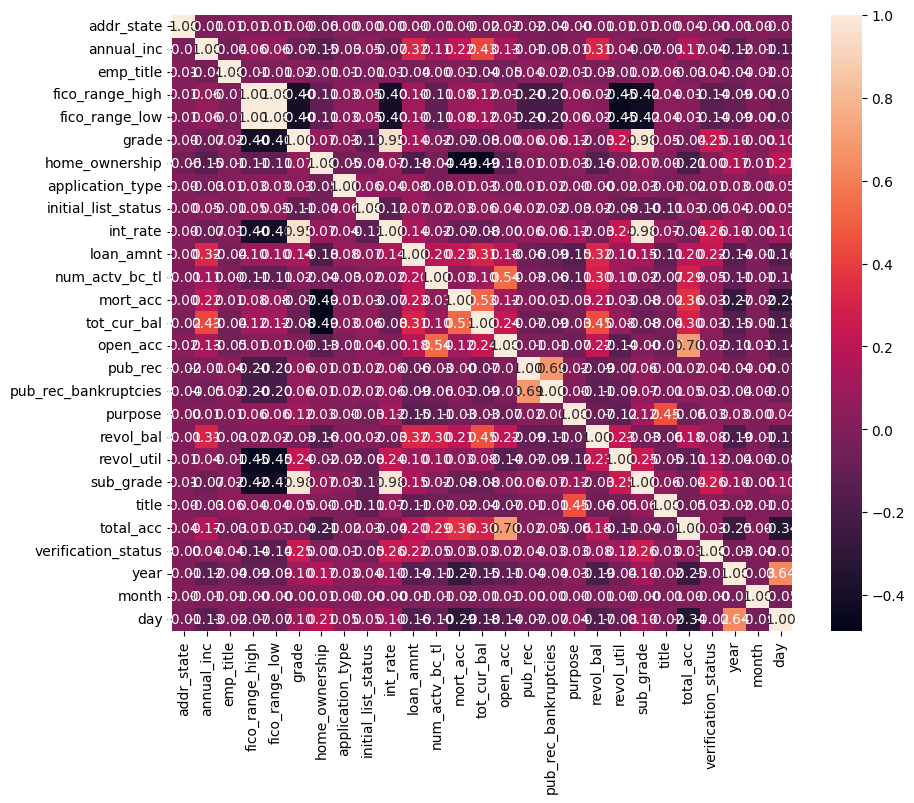

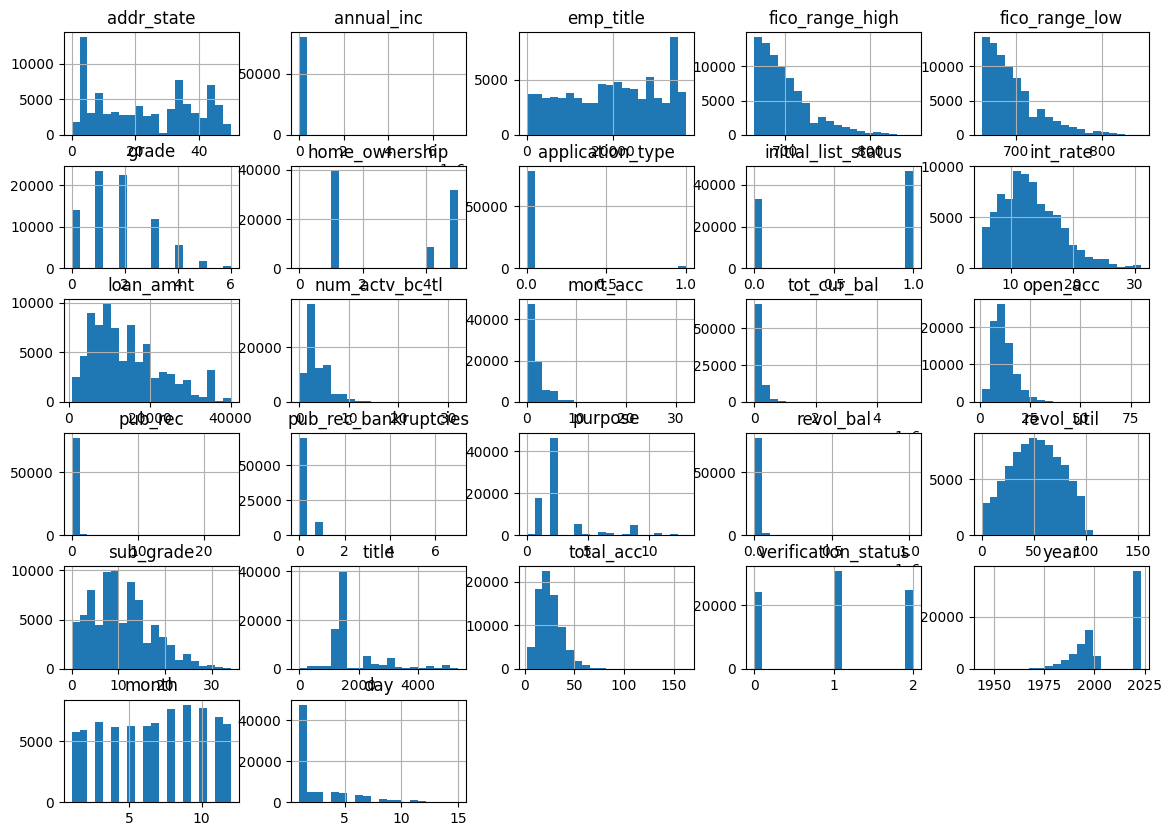

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

# Summary statistics for numeric columns
print(df.describe())

# Frequency of categories for categorical columns
print(df['emp_length'].value_counts())

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.show()

# Histograms
df.hist(bins=20, figsize=(14, 10))
plt.show()


In [ ]:
# Analyzing loan status by employment length
sns.countplot(x='emp_length', hue='loan_status', data=df)
plt.show()

# Addressing missing values with domain knowledge
# e.g., fill missing employment length with mode for a certain job title
df['emp_length'].fillna(df.groupby('emp_title')['emp_length'].transform(lambda x: x.mode()), inplace=True)


Data Preprocessing pickle object building

In [72]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
import pandas as pd

class DataPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, median_fill_cols, earliest_cr_line, emp_length, term_column, string_cols, encode_cols):
        self.median_fill_cols = median_fill_cols
        self.earliest_cr_line = earliest_cr_line
        self.emp_length = emp_length
        self.term_column = term_column
        self.string_cols = string_cols
        self.encode_cols = encode_cols
        self.encoders = {column: LabelEncoder() for column in encode_cols}

    def fit(self, X, y=None):
        # We only need to fit the LabelEncoders
        for col in self.encode_cols:
            if X[col].dtype == 'object':
                self.encoders[col].fit(X[col].astype(str))
        return self

    def transform(self, X, y=None):
        # Fill NaN with median
        for col in self.median_fill_cols:
            X[col].fillna(X[col].median(), inplace=True)

        # Convert date column into separate year, month, day columns
        X[self.earliest_cr_line] = pd.to_datetime(X[self.earliest_cr_line], format='%Y-%m-%d')
        X['year'] = X[self.earliest_cr_line].dt.year
        X['month'] = X[self.earliest_cr_line].dt.month
        X['day'] = X[self.earliest_cr_line].dt.day
        X.drop(columns=[self.earliest_cr_line], inplace=True)

        # Clean employment length column
        X[self.emp_length] = X[self.emp_length].str.replace('years', '').str.replace('year', '').str.replace('<', '').str.replace('+', '').str.strip()

         # Fill NaN with median for the employment length column
        X[self.emp_length].fillna(X[self.emp_length].median(), inplace=True)

        # Clean term column
        X[self.term_column] = X[self.term_column].str.replace('months', '').str.strip()

        # Convert columns to strings
        X[self.string_cols] = X[self.string_cols].astype(str)

        # Encode columns with handling for unseen values
        for col in self.encode_cols:
            if col in X.columns:
                # Temporarily fill unknown values with a placeholder
                X[col] = X[col].apply(lambda x: x if x in self.encoders[col].classes_ else '<Unknown>')
                # Update the encoder's classes_ attribute to handle the placeholder for unknowns
                self.encoders[col].classes_ = np.append(self.encoders[col].classes_, '<Unknown>')
                # Transform the data
                X[col] = self.encoders[col].transform(X[col])

        return X


# Instantiate the preprocessor
median_fill_cols = ['num_actv_bc_tl', 'mort_acc', 'tot_cur_bal', 'pub_rec_bankruptcies', 'revol_util']
date_column = 'earliest_cr_line'
emp_length = 'emp_length'
term_column = 'term'
string_cols = ['addr_state', 'emp_title', 'home_ownership', 'application_type', 'initial_list_status', 'sub_grade', 'title', 'verification_status', 'purpose', 'grade']
encode_cols = string_cols.copy()  # Assuming all string columns will be encoded

preprocessor = DataPreprocessor(
    median_fill_cols=median_fill_cols,
    earliest_cr_line=date_column,
    emp_length=emp_length,
    term_column=term_column,
    string_cols=string_cols,
    encode_cols=encode_cols
)

# Fit the preprocessor to the training data
preprocessor.fit(df)

# Now you can transform the training data
df_preprocessed = preprocessor.transform(df)

# And later on, you can use the same preprocessor object for new data
# new_data_preprocessed = preprocessor.transform(new_data)


<ipython-input-72-414a7ea35df4>:35: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X[self.emp_length] = X[self.emp_length].str.replace('years', '').str.replace('year', '').str.replace('<', '').str.replace('+', '').str.strip()


In [73]:
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

with open('preprocessor.pkl', 'rb') as f:
    loaded_preprocessor = pickle.load(f)


In [74]:
df_preprocessed.isnull().sum()


addr_state              0
annual_inc              0
emp_length              0
emp_title               0
fico_range_high         0
fico_range_low          0
grade                   0
home_ownership          0
application_type        0
initial_list_status     0
int_rate                0
loan_amnt               0
num_actv_bc_tl          0
mort_acc                0
tot_cur_bal             0
open_acc                0
pub_rec                 0
pub_rec_bankruptcies    0
purpose                 0
revol_bal               0
revol_util              0
sub_grade               0
term                    0
title                   0
total_acc               0
verification_status     0
loan_status             0
year                    0
month                   0
day                     0
dtype: int64

In [80]:
# Define the new order for the columns
new_order = [
    'addr_state', 'annual_inc', 'emp_length', 'emp_title',
    'fico_range_high', 'fico_range_low', 'grade', 'home_ownership',
    'application_type', 'initial_list_status', 'int_rate', 'loan_amnt',
    'num_actv_bc_tl', 'mort_acc', 'tot_cur_bal', 'open_acc', 'pub_rec',
    'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util',
    'sub_grade', 'term', 'title', 'total_acc', 'verification_status',
    'year', 'month', 'day', 'loan_status'
]

# Reorder the columns in the DataFrame
df_preprocessed = df_preprocessed[new_order]


In [75]:
val_df_preprocessed = loaded_preprocessor.transform(val_data)
val_df_preprocessed

<ipython-input-72-414a7ea35df4>:35: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X[self.emp_length] = X[self.emp_length].str.replace('years', '').str.replace('year', '').str.replace('<', '').str.replace('+', '').str.strip()


,addr_state,annual_inc,emp_length,emp_title,fico_range_high,fico_range_low,grade,home_ownership,application_type,initial_list_status,...,revol_bal,revol_util,sub_grade,term,title,total_acc,verification_status,year,month,day
0,24,50000.0,1,29351,719,715,2,4,0,0,...,2568,9.8,13,36,1510,11,1,2012,5,1
1,11,92000.0,10,27937,684,680,1,5,0,0,...,30394,75.4,6,36,1510,35,1,2001,12,1
2,43,89000.0,10,36662,679,675,1,1,0,1,...,38400,75.3,6,60,1147,41,0,1989,3,1
3,4,33000.0,9,24560,674,670,2,5,0,0,...,21224,69.4,10,36,405,16,0,2004,11,1
4,22,35580.0,6.0,34554,704,700,1,1,0,0,...,3471,39.4,9,36,5349,19,2,1997,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,24,38500.0,4,36662,679,675,3,5,0,1,...,5816,60.0,18,36,1510,10,0,2010,9,1
19996,45,80000.0,3,36662,674,670,3,1,0,0,...,13886,75.1,18,60,1510,30,1,1998,12,1
19997,43,95000.0,10,20639,729,725,1,1,0,0,...,43166,60.7,9,36,1510,29,1,1996,5,1
19998,9,35000.0,10,16835,809,805,0,1,0,1,...,1110,4.4,4,36,585,19,0,2003,3,1


In [76]:
val_df_preprocessed.isnull().sum()


addr_state              0
annual_inc              0
emp_length              0
emp_title               0
fico_range_high         0
fico_range_low          0
grade                   0
home_ownership          0
application_type        0
initial_list_status     0
int_rate                0
loan_amnt               0
num_actv_bc_tl          0
mort_acc                0
tot_cur_bal             0
open_acc                0
pub_rec                 0
pub_rec_bankruptcies    0
purpose                 0
revol_bal               0
revol_util              0
sub_grade               0
term                    0
title                   0
total_acc               0
verification_status     0
year                    0
month                   0
day                     0
dtype: int64

Building the ML model

In [84]:

X = df_preprocessed.iloc[:, :-1]  # All columns except the last one
y = df_preprocessed.iloc[:, -1]   # Only the last column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train and y_train are now the features and labels for the training set
# X_test and y_test are the features and labels for the test set


In [97]:
from sklearn.metrics import accuracy_score, f1_score

# Initialize the models
logreg = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=100)
gbc = GradientBoostingClassifier(n_estimators=100)

# A dictionary to keep track of the accuracies and F1 scores
accuracies = {}
f1_scores = {}

# Train and evaluate Logistic Regression
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
accuracies['Logistic Regression'] = accuracy_score(y_test, y_pred_logreg)
f1_scores['Logistic Regression'] = f1_score(y_test, y_pred_logreg, average='weighted')

# Train and evaluate Random Forest
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
accuracies['Random Forest'] = accuracy_score(y_test, y_pred_rf)
f1_scores['Random Forest'] = f1_score(y_test, y_pred_rf, average='weighted')

# Train and evaluate Gradient Boosting
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)
accuracies['Gradient Boosting'] = accuracy_score(y_test, y_pred_gbc)
f1_scores['Gradient Boosting'] = f1_score(y_test, y_pred_gbc, average='weighted')

# Print out the accuracies and F1 scores for comparison
for model in accuracies.keys():
    print(f"{model} - Accuracy: {accuracies[model]:.4f}, F1 Score: {f1_scores[model]:.4f}")


Logistic Regression - Accuracy: 0.8053, F1 Score: 0.7379
Random Forest - Accuracy: 0.8050, F1 Score: 0.7377
Gradient Boosting - Accuracy: 0.8064, F1 Score: 0.7328


In [101]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from joblib import dump

# Define a scoring function
f1_scorer = make_scorer(f1_score, average='weighted')

# Set up the hyperparameter grid for Logistic Regression
logreg_param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'solver': ['liblinear', 'saga']  # Algorithm to use in the optimization problem
}

# Initialize GridSearchCV with Logistic Regression estimator
logreg_grid_search = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid=logreg_param_grid,
    scoring=f1_scorer,
    cv=5  # Number of cross-validation folds
)

# Fit the model
logreg_grid_search.fit(X_train, y_train)

# Get the best parameters and the corresponding accuracy and F1 score
best_logreg_params = logreg_grid_search.best_params_
best_logreg_score = logreg_grid_search.best_score_

# Assuming `logreg_grid_search` is your GridSearchCV object for Logistic Regression
best_logreg_model = logreg_grid_search.best_estimator_
dump(best_logreg_model, 'best_logistic_regression_model.joblib')

# Predict on the test set with the best found parameters
y_pred_logreg = logreg_grid_search.predict(X_test)

# Calculate test set accuracy and F1 score
logreg_test_accuracy = accuracy_score(y_test, y_pred_logreg)
logreg_test_f1_score = f1_score(y_test, y_pred_logreg, average='weighted')

print(f"Logistic Regression - Best CV Params: {best_logreg_params}")
print(f"Logistic Regression - Best CV F1 Score: {best_logreg_score:.4f}")
print(f"Logistic Regression - Test Accuracy: {logreg_test_accuracy:.4f}")
print(f"Logistic Regression - Test F1 Score: {logreg_test_f1_score:.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Logistic Regression - Best CV Params: {'C': 1, 'solver': 'liblinear'}
Logistic Regression - Best CV F1 Score: 0.7247
Logistic Regression - Test Accuracy: 0.8051
Logistic Regression - Test F1 Score: 0.7416


In [98]:
import pickle

# Let's say the best model was the Random Forest model
best_model = rf  # This would be the model instance like `rf` from the earlier example

# Save the model to a file
with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print("Model saved as 'best_model.pkl'")


Model saved as 'best_model.pkl'


In [87]:
# Load the model from the file
with open('best_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)



In [89]:
predictions = loaded_model.predict(val_df_preprocessed)

In [91]:
predictions_df = pd.DataFrame(predictions)
predictions_df

,0
0,Paid
1,Paid
2,Paid
3,Paid
4,Paid
...,...
19995,Paid
19996,Paid
19997,Paid
19998,Paid


In [102]:

# Save the DataFrame to a text file
predictions_df.to_csv('predictions.txt', sep='\t', index=False)

print("Predictions saved to predictions.txt")

Predictions saved to predictions.txt


In [93]:
val_data_wt_predictions = pd.concat([val_df_preprocessed, predictions_df], axis=1)


In [94]:
val_data_wt_predictions

,addr_state,annual_inc,emp_length,emp_title,fico_range_high,fico_range_low,grade,home_ownership,application_type,initial_list_status,...,revol_util,sub_grade,term,title,total_acc,verification_status,year,month,day,0
0,24,50000.0,1,29351,719,715,2,4,0,0,...,9.8,13,36,1510,11,1,2012,5,1,Paid
1,11,92000.0,10,27937,684,680,1,5,0,0,...,75.4,6,36,1510,35,1,2001,12,1,Paid
2,43,89000.0,10,36662,679,675,1,1,0,1,...,75.3,6,60,1147,41,0,1989,3,1,Paid
3,4,33000.0,9,24560,674,670,2,5,0,0,...,69.4,10,36,405,16,0,2004,11,1,Paid
4,22,35580.0,6.0,34554,704,700,1,1,0,0,...,39.4,9,36,5349,19,2,1997,2,1,Paid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,24,38500.0,4,36662,679,675,3,5,0,1,...,60.0,18,36,1510,10,0,2010,9,1,Paid
19996,45,80000.0,3,36662,674,670,3,1,0,0,...,75.1,18,60,1510,30,1,1998,12,1,Paid
19997,43,95000.0,10,20639,729,725,1,1,0,0,...,60.7,9,36,1510,29,1,1996,5,1,Paid
19998,9,35000.0,10,16835,809,805,0,1,0,1,...,4.4,4,36,585,19,0,2003,3,1,Paid
